Key Components

StateGraph: The core of our application, defining the flow of our Travel Planner.

PlannerState: A custom type representing the state of our planning process.

Node Functions: Individual steps in our planning process (input_city, input_interests, create_itinerary).

LLM Integration: Utilizing a language model to generate the final itinerary.
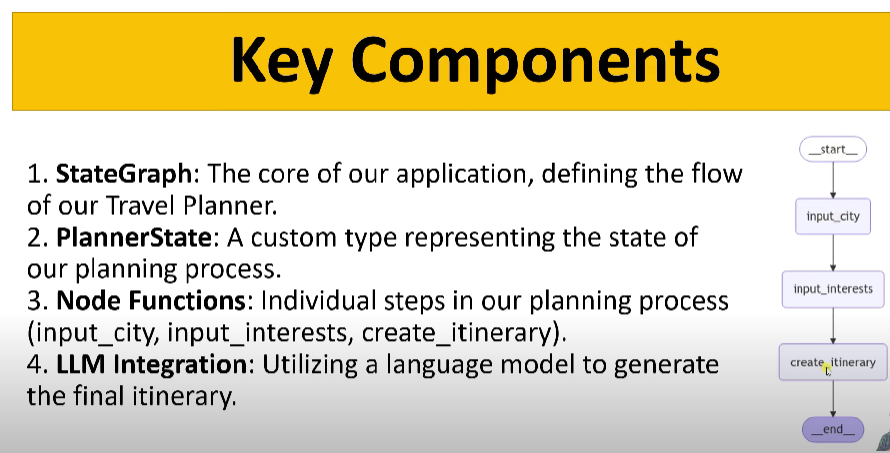

In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 10.3 MB/s eta 0:00:00


In [ ]:
import os
from typing import TypedDict,Annotated,List
from langgraph.graph import StateGraph,END
from langchain_core.messages import HumanMessage,AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display,Image

**Define Agent**


In [ ]:
class PlannerState(TypedDict):
  messages : Annotated[list[HumanMessage | AIMessage],"the messages is in the conversation"]
  city : str
  interests : List[str]
  itinerary : str

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "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",
    model_name="llama-3.3-70b-versatile"
    )
result = llm.invoke("What is multi AI Agent?")
result.content

'A multi-agent system is a system composed of multiple autonomous agents that interact with each other and their environment to achieve a common goal or set of goals. In the context of artificial intelligence (AI), a multi-agent system is a collection of AI agents that work together to solve a problem or complete a task.\n\nEach agent in a multi-agent system has its own capabilities, goals, and knowledge, and they may have different perspectives, beliefs, and intentions. The agents can communicate with each other, share information, and coordinate their actions to achieve a common objective.\n\nMulti-agent systems can be classified into different types, including:\n\n1. **Cooperative multi-agent systems**: Agents work together to achieve a common goal, sharing information and resources.\n2. **Competitive multi-agent systems**: Agents compete with each other to achieve their individual goals, often in a game-like setting.\n3. **Hybrid multi-agent systems**: Agents may cooperate or compe

In [ ]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system","You are a travel planner.Create a day trip itinernary for {city} based on the user's interests: {interests}. Provide a brief, bulleted intinerary"),
    ("human","Create an intinerary for my day trip." )
])

**Define Agent Function**

In [ ]:
def input_city(state: PlannerState)-> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your input: ")
  return{
      **state,
      "city":user_message,
      "messages" :state['messages'] + [HumanMessage(content=user_message)]
  }
def input_interest(state: PlannerState)-> PlannerState:
  print(f"Please enter your interest for the trip to {state['city']} (comman-seperated): ")
  user_message = input("Your input: ")
  return{
      **state,
      "interests":[interest.strip() for interest in user_message.split(",")],
      "messages" :state['messages'] + [HumanMessage(content=user_message)]
  }

def create_itinerary(state: PlannerState)-> PlannerState:
  print(f"Creating itinerary for {state['city']} based on interests:{','.join(state['interests'])} ")
  response = llm.invoke(itinerary_prompt.format_prompt(city=state['city'],interests=','.join(state['interests'])))
  print("\nFinal Itinerary:")
  print(response.content)
  return{
    **state,
    "messages" :state['messages'] + [AIMessage(content=response.content)],
    "itinerary":response.content,
  }

**Create and Compile the Graph**

In [ ]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city",input_city)
workflow.add_node("input_interests",input_interest)
workflow.add_node("create_itinerary",create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city","input_interests")
workflow.add_edge("input_interests","create_itinerary")
workflow.add_edge("create_itinerary",END)

app = workflow.compile()

**Display the graph structure**

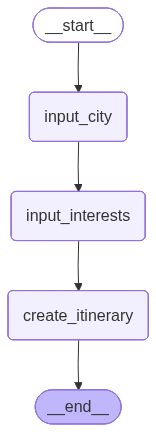

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

**Define the function that run the graph**

In [ ]:
def travel_planner(user_request: str):
  print(f"initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content = user_request)],
      "city": "",
      "interests": [],
      "itinerary" : "",
  }
  for output in app.stream(state):
    pass

In [ ]:
user_request = "I want to plan a day trip"
travel_planner(user_request)


initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your input: Pune
Please enter your interest for the trip to Pune (comman-seperated): 
Your input: Dagdusheth,Somwarpeth
Creating itinerary for Pune based on interests:Dagdusheth,Somwarpeth 

Final Itinerary:
Here's a brief, bulleted itinerary for your day trip to Pune based on your interests in Dagdusheth and Somwarpeth:

* 9:00 AM: Start the day with a visit to the famous **Dagdusheth Halwai Ganpati Temple**, a iconic landmark in Pune.
* 11:00 AM: Explore the nearby **Somwarpeth** area, known for its traditional Marathi cuisine, local shops, and historic architecture.
* 1:00 PM: Take a break for lunch at a local restaurant in Somwarpeth, trying some authentic Pune dishes like misal pav or puran poli.
* 2:30 PM: Visit the **Laxmi Road** nearby, which offers a range of shopping and snacking options, from street food to traditional sweets.
* 5:00 PM: End the day with a visit to the **V

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def gradio_travel_planner(city: str, interests: str) -> str:
    """
    Wrapper function to adapt the travel_planner for Gradio.
    """
    # The original travel_planner function prints the output,
    # we need to capture that output or modify the function
    # to return the itinerary. For simplicity, we'll modify the
    # create_itinerary function to return the itinerary and
    # print it.

    # Re-define create_itinerary to return the itinerary
    def create_itinerary_for_gradio(state: PlannerState) -> PlannerState:
        print(f"Creating itinerary for {state['city']} based on interests:{','.join(state['interests'])} ")
        response = llm.invoke(itinerary_prompt.format_prompt(city=state['city'], interests=','.join(state['interests'])))
        itinerary_content = response.content
        print("\nFinal Itinerary:")
        print(itinerary_content) # Still print for debugging/visibility
        return {
            **state,
            "messages": state['messages'] + [AIMessage(content=itinerary_content)],
            "itinerary": itinerary_content,
        }

    # Create a temporary workflow with the modified create_itinerary
    gradio_workflow = StateGraph(PlannerState)
    gradio_workflow.add_node("input_city", lambda state: {**state, "city": city})
    gradio_workflow.add_node("input_interests", lambda state: {**state, "interests": [interest.strip() for interest in interests.split(",")]})
    gradio_workflow.add_node("create_itinerary", create_itinerary_for_gradio)

    gradio_workflow.set_entry_point("input_city")
    gradio_workflow.add_edge("input_city", "input_interests")
    gradio_workflow.add_edge("input_interests", "create_itinerary")
    gradio_workflow.add_edge("create_itinerary", END)

    gradio_app = gradio_workflow.compile()

    # Run the workflow and return the final itinerary
    initial_state = {"messages": [], "city": "", "interests": [], "itinerary": ""}
    final_state = gradio_app.invoke(initial_state)
    return final_state.get("itinerary", "Could not generate itinerary.")


# Create the Gradio interface
iface = gr.Interface(
    fn=gradio_travel_planner,
    inputs=[
        gr.Textbox(label="City"),
        gr.Textbox(label="Interests (comma-separated)")
    ],
    outputs=gr.Textbox(label="Itinerary"),
    title="Travel Planner"
)

# Launch the interface
iface.launch(share=True,debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6d5c654c1dd872a0a0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Creating itinerary for pune based on interests:fc road 


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 745, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 353, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1623, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Creating itinerary for pune based on interests:fc road 


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 745, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 353, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1623, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^